<img width="800px" src="../images/img/001.png"></img>
# NOM DU PROJET: **Application mobile d'aide à la conduite  de reconnaissance des panneau de circulation routiere**
# <!-- TITLE --> Etape2-  Suivi de l'entraînement
<!--Auteur : Tchotaneu Ngatcha Giresse (INSTITUTE FRANCOPHONE INTERNATIONAL) -->

lien de telechargement : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

##  Ce que nous allons realiser:

 - Suivre et comprendre la formation de notre modèle 
 - Ajouter des points de récupération
 - Analyser les résultats 
 - Restaurer et exécuter les points de récupération

 ## 1: preparation de l'environement de travail (importation des bibiotheque utiles )

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix
from skimage import io, transform, color

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload
import mesFonctionsPersonnelles.fonctionDeBase as projet
sys.path.append('..')
run_dir = './run/GTSRB3.001'
datasets_dir =  projet.init('GTSRB3', run_dir)

<br>**Projet de reconnaissance de forme**

Version              : 2.0.35
Notebook id          : GTSRB3
Run time             : Wednesday 26 October 2022, 14:36:07
Hostname             : DESKTOP-36O6V1H (Windows)
Tensorflow log level : Info + Warning + Error  (=0)
Datasets dir         : C:\Users\TCHOTANEU\LesProjetsGiresse\datasets
Run dir              : ./run/GTSRB3.001
Update keras cache   : False
tensorflow           : 2.9.1
tensorflow.keras     : 2.9.0
numpy                : 1.23.2
sklearn              : 1.1.2
skimage              : 0.19.3
matplotlib           : 3.5.3
pandas               : 1.4.3


In [4]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 10
scale        = 1
fit_verbosity = 1

Un jeu de données 24x24, avec 5 époques et une échelle de 1, nécessite 3'30 sur un ordinateur portable CPU.
`fit_verbosity` est la verbosité pendant l'apprentissage : 0 = silencieux, 1 = barre de progression, 2 = une ligne par époch.

In [5]:
 projet.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale', 'fit_verbosity')

## Étape 2 - Charger le jeu de données
Le dataset  est deja  enregistrés dans notre machine : RGB25, RGB35, L25, L35, etc.  
Tout d'abord, nous allons utiliser un jeu de données: **set-24x24-L** 

In [9]:
def read_dataset(enhanced_dir, dataset_name):
    # ---- 
    projet.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ----melange
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- 
    duration =  projet.chrono_stop(hdelay=True)
    size     =  projet.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- lire 
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- 
#
x_train,y_train, x_test,y_test =  projet.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)
Dataset "set-24x24-L" is loaded and shuffled. (228.6 Mo in 00:00:00 189ms)


## Étape 3 - Regardez l'ensemble de données
 Les données doivent être remodelées pour affichage.

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


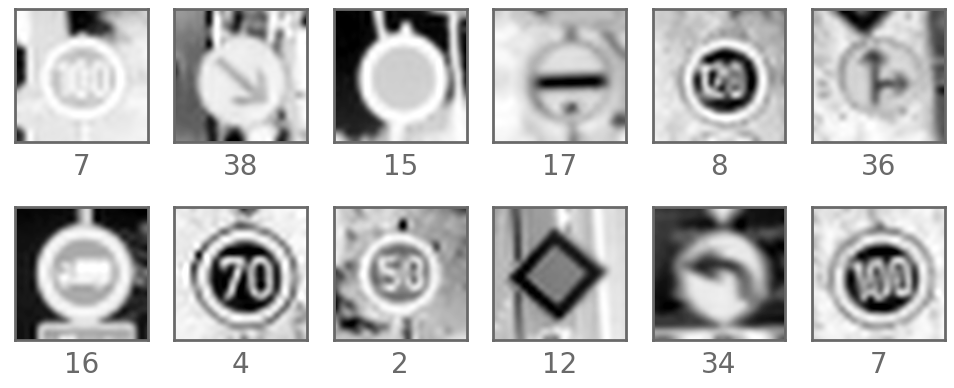

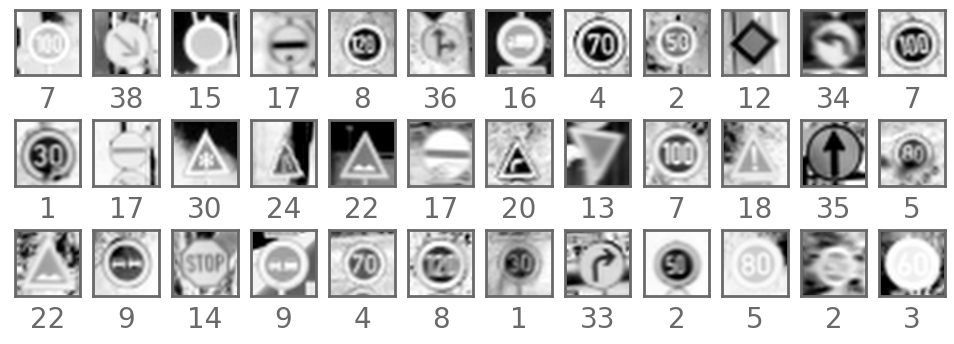

In [10]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

projet.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
projet.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Étape 4 - Création du modèle
contruction du modele et apprentissage 

In [11]:

def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Étape 5 - Préparer les callbacks  
Nous allons ajouter 2 callbacks :  

**TensorBoard**  
Les journaux d'entraînement, qui peuvent être visualisés à l'aide de [l'outil Tensorboard] (https://www.tensorflow.org/tensorboard).  

**Sauvegarde du modèle**  
 Il est possible de sauvegarder le modèle à chaque xx époque ou à chaque amélioration.  
 Le modèle peut être sauvegardé complètement ou partiellement (poids).  
 Pour le format complet, on peut utiliser le format HDF5.

In [12]:
projet.mkdir(run_dir + '/models')
projet.mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + projet.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - sauvegarde du meilleur  model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Sauvegarde du model a chaque epoque
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath(f'{run_dir}/logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir C:\Users\TCHOTANEU\LesProjetsGiresse\Projets\GTSRB\run\GTSRB3.001\logs


## Étape 6 - Entraînement du modèle
**Redecouvrons la forme de mes données :**

In [13]:
(n,lx,ly,lz) = x_train.shape
print("Les images du dataset ont la forme suivante : ",(lx,ly,lz))

Les images du dataset ont la forme suivante :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [14]:
model = get_model_v1(lx,ly,lz)

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 192)         166080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 192)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 192)         0

**Entraînez-le :**  
La courbe d'entraînement est visible en temps réel avec Tensorboard.

In [16]:
projet.chrono_start()

# ---- Shuffle train data
x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

# ---- Train
# Note: To be faster in our example, we can take only 2000 values
#
history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=fit_verbosity,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

projet.chrono_show()

Epoch 1/10
613/613 [==============================] - 63s 102ms/step - loss: 0.3861 - accuracy: 0.8901 - val_loss: 0.3599 - val_accuracy: 0.9120
Epoch 2/10
613/613 [==============================] - 62s 101ms/step - loss: 0.1614 - accuracy: 0.9537 - val_loss: 0.3041 - val_accuracy: 0.9266
Epoch 3/10
613/613 [==============================] - 62s 101ms/step - loss: 0.1053 - accuracy: 0.9691 - val_loss: 0.2753 - val_accuracy: 0.9367
Epoch 4/10
613/613 [==============================] - 61s 99ms/step - loss: 0.0816 - accuracy: 0.9755 - val_loss: 0.2353 - val_accuracy: 0.9458
Epoch 5/10
613/613 [==============================] - 60s 97ms/step - loss: 0.0589 - accuracy: 0.9825 - val_loss: 0.2424 - val_accuracy: 0.9442
Epoch 6/10
613/613 [==============================] - 61s 100ms/step - loss: 0.0533 - accuracy: 0.9838 - val_loss: 0.2870 - val_accuracy: 0.9408
Epoch 7/10
613/613 [==============================] - 61s 100ms/step - loss: 0.0446 - accuracy: 0.9869 - val_loss: 0.2720 - val_accu

## **Evaluation :**

In [17]:
max_val_accuracy = max(history.history["val_accuracy"])
print("La valeur maximal de Accurancy est de   : {:.4f}".format(max_val_accuracy))

La vvaleur maximal de Accurancy est de   : 0.9493


In [18]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test perte      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test perte      : 0.2730
Test accuracy  : 0.9437


## Étape 7 - Historique

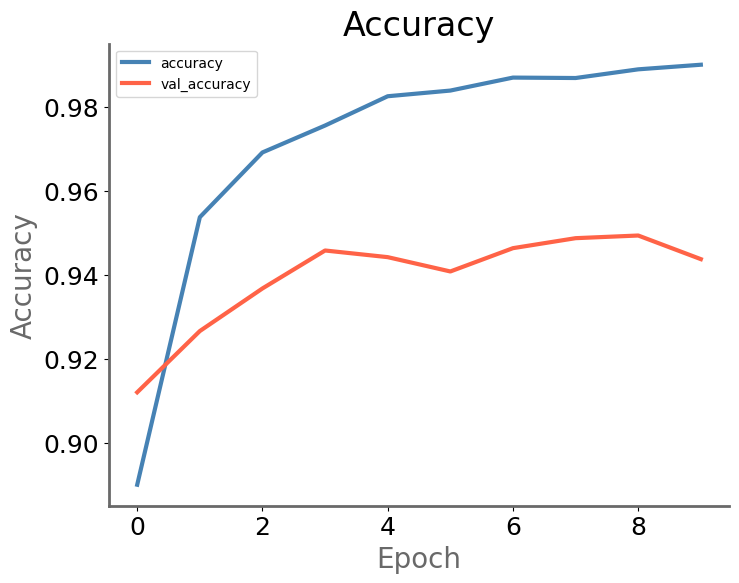

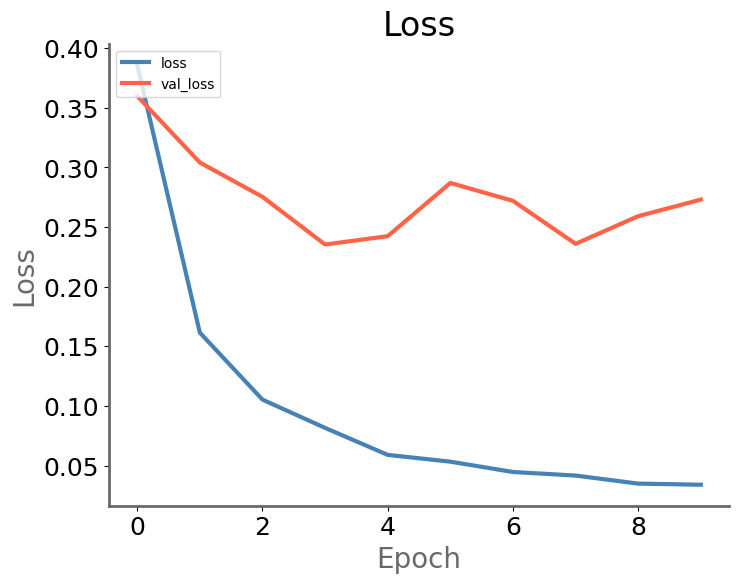

In [19]:
projet.plot_history(history, save_as='03-history')

### Étape 8 - Évaluation et Matrice de confusion

395/395 [==============================] - 5s 13ms/step


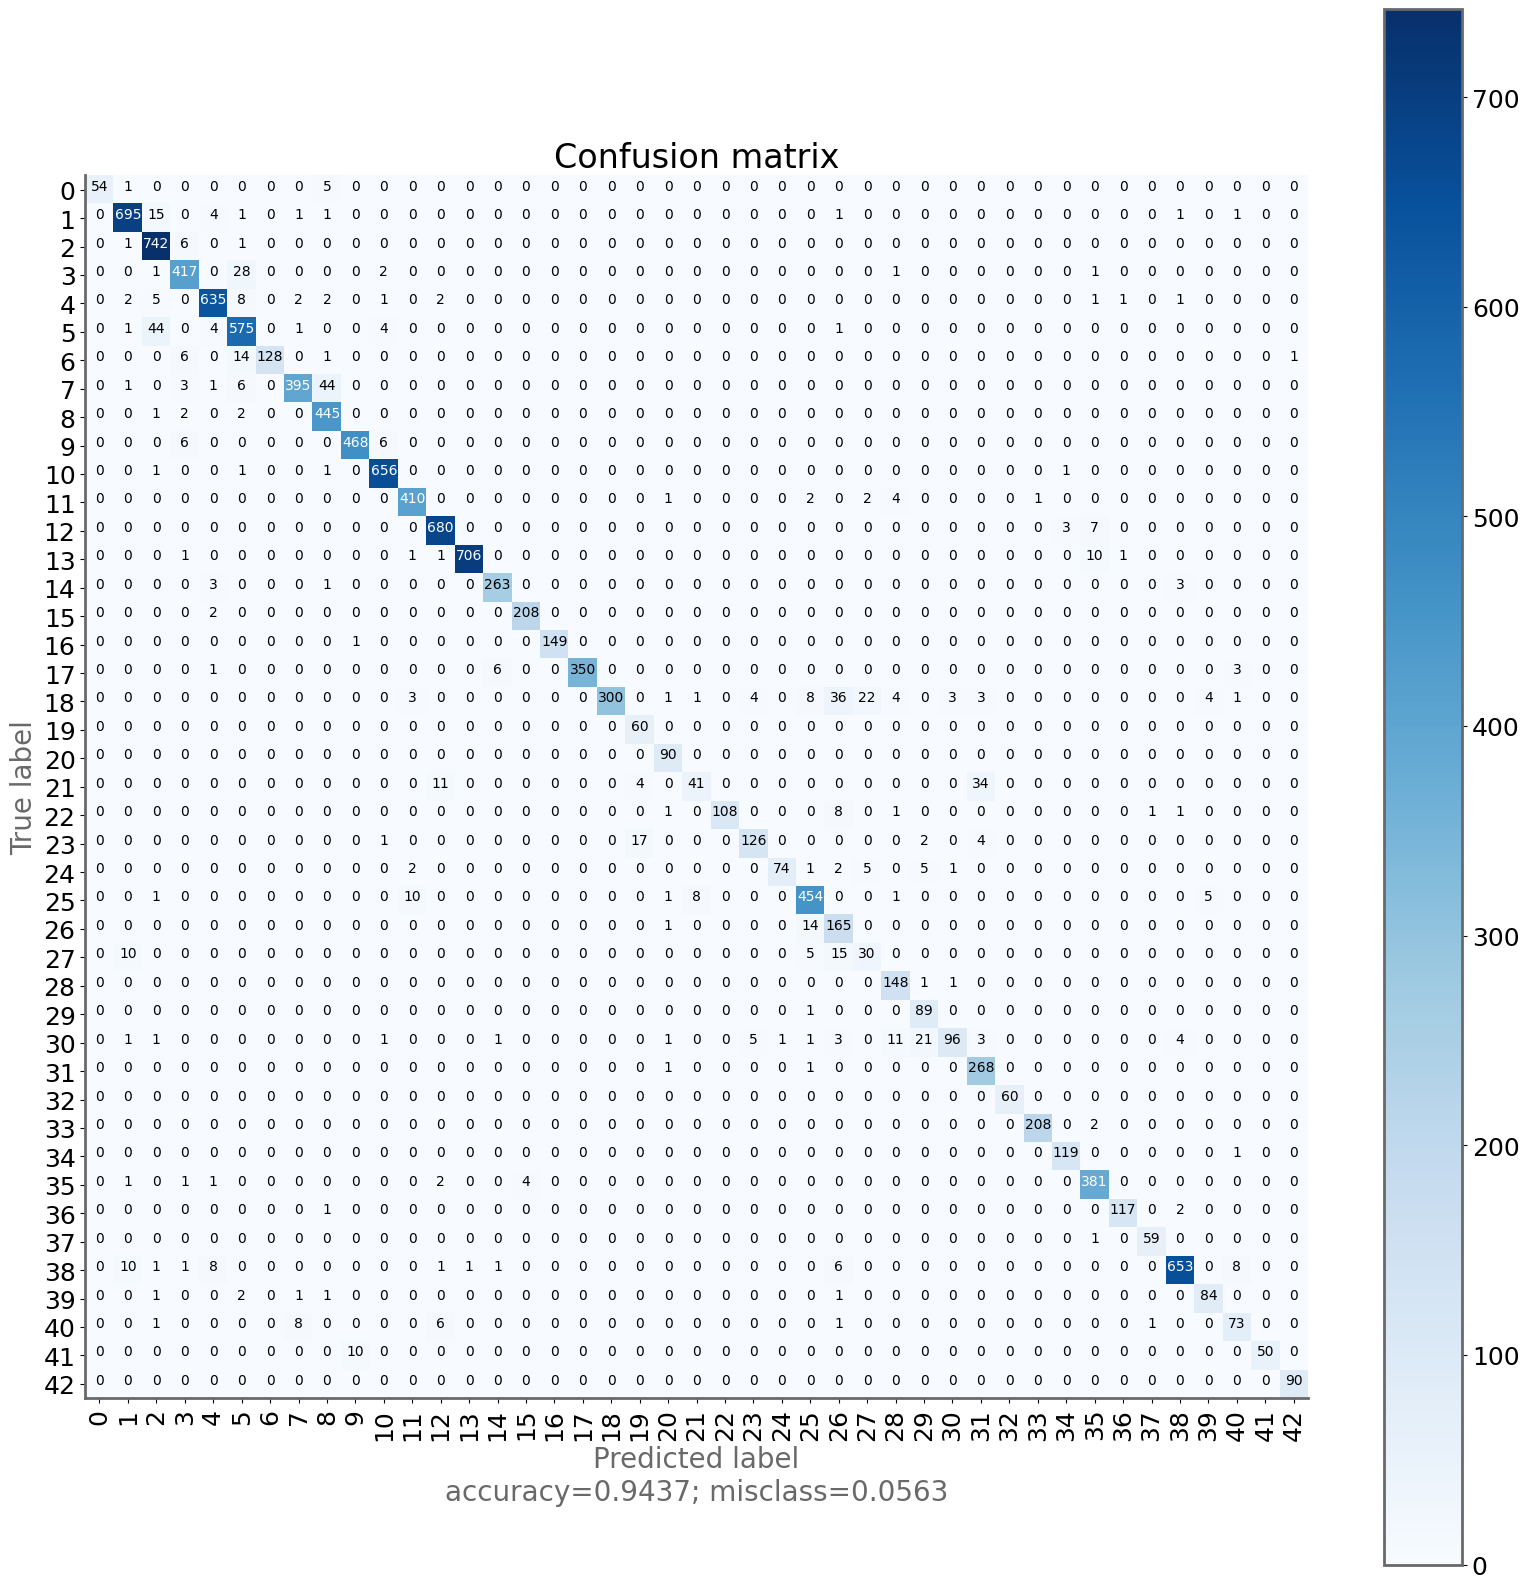

In [21]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

projet.plot_confusion_matrix(y_test,y_pred,range(43), figsize=(16, 16),normalize=False, save_as='04-confusion-matrix')

### Étape 9 - Restaurer et évaluer
### 9.1 - Liste des modèles sauvegardés :

In [22]:
!find "$run"/models

FINDÿ: format incorrect de paramŠtre


### 9.2 - Restore a model :

In [24]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
loaded_model.summary()
print("loaded_model")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 192)         166080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 192)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 192)         0

### 9.3 - Evaluate it :

In [25]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2730
Test accuracy  : 0.9437


### 9.4 - faire des prediction :

1/1 [==============================] - 0s 128ms/step

La couche de sortie du modèle est (x100) :

[[  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]]

Histogramme :



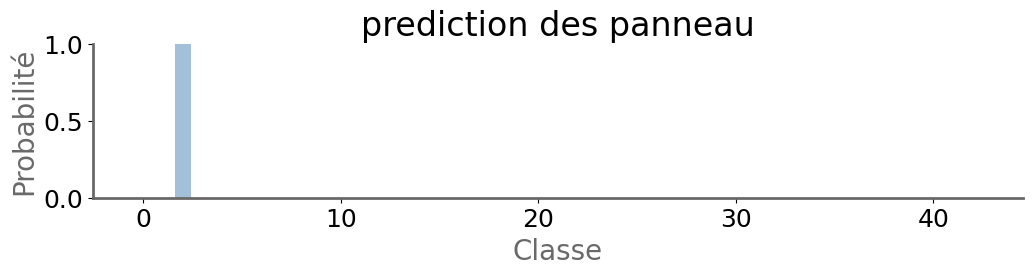


l'image :                            la Prediction :                       ce qu'on veut:


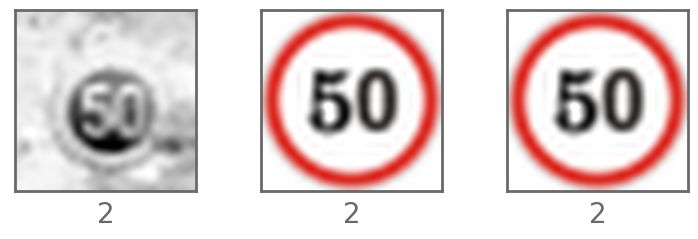

oui  ! bonne predition!


In [38]:
# ----changeons les images aleatoirements
#
i   = random.randint(1,len(x_test))
x,y = x_test[i], y_test[i]

# ---- faire la prediction
#
predictions = loaded_model.predict( np.array([x]) )

# ----
#
print("\nLa couche de sortie du modèle est (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nHistogramme :\n")
plt.figure(figsize=(12,2))
plt.bar(range(43), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probabilité')
plt.ylim((0,1))
plt.xlabel('Classe')
plt.title('prediction des panneau')
projet.save_fig('05-prediction-proba')
plt.show()

# ---- Prediction de la classe classe
#
p = np.argmax(predictions)

# ----affichage du resultat 
#
print("\nl'image :                            la Prediction :                       ce qu'on veut:")
projet.plot_images([x,x_meta[p], x_meta[y]], [p,p,y], range(3),  columns=3,  x_size=3, y_size=2, save_as='06-prediction-images')

if p==y:
    print("oui  ! bonne predition!")
else:
    print("non , mauvaise prediction;-(")

## test avec les donnees reels dataset hanoi

# nous avons utilse le dataset set-24x24-L donc utlise nos donnes sur notre modele nous allons recupere l'image et een suite le faire un pretraite avant de le passer  au modele enfin d'observer la classe de prediction 

In [29]:
projet.end()

**Fin du traitement :** Wednesday 26 October 2022, 14:32:17  
**Durée :** 01:16:15 043ms  
Notre notebook se termine ici ,le code est disponible sur  :-)  
[https://github.com/tchotaneu](https://github.com/tchotaneu)